# SVM Model to Predict CIRI scores based on State Department Annual Reports

## Gareth Walker

SVM text classifier model trains on state department reports and CIRI data.
Stores most predictive words for CIRI scores.
Predicts 2016,2017,2018 CIRI Scores

#### Inputs
CIRI_Text_1999_2015.csv : Used to train model 
us_state_dept_reports_1999_2018.csv: Used to predict CIRI scores

#### Outputs

Stores predictions, model performance , and most important features (words) for each CIRI score in pandas DBs: 
Model Predictions of CIRI Scores: 			(‘../data/SVM_Predictions.csv')
Model Features: 						(‘../data/SVM_Features.csv')
Model Train Test Split Performance Data :	 (‘../data/SVM_Performance.csv')


In [1]:
import pandas as pd
import sqlite3 as sql

# Define cleaning functions

In [2]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/garethwalker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from sklearn.model_selection import train_test_split
from string import digits


import re


from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))


from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.util import ngrams

def convert(list): 
      
    # Converting integer list to string list 
    s = [str(i) for i in list] 
    
    # Join list items using join()
    s = (" ".join(s)) 
    

    return(s) 


def clean_text(s):
    
    # Convert to lowercase
    s = s.lower()
    
    # remove URLs
    s = re.sub(r"http\S+", "", s)
    
    s = s.replace('\n',' ')

    s = s.replace( "\"", '' )
    
    # Remove aposrphe
    s =s.replace("'", "")
    
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)

    # Repace all punctuatin with spaces
    s = re.sub(r'[^\w\s]',' ',s)

    #remove digits
    remove_digits = str.maketrans('', '', digits)
    s = s.translate(remove_digits)
    
    # remove isolated numbers (like years)
    #s = re. sub ('\b\d+\b','', s)
    
    # replace all double spaces, tabes, and returns
    s= re.sub(' +', ' ',s)
    

    
    
    
    return(s)



def stem_word(text):
    
    stemmed = []
    stemmer = LancasterStemmer()
    
    for w in text:
        stemmed.append(stemmer.stem(w))
        
    return (stemmed)


def generate_ngrams(st, n):
    
   
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.split(" ") if token != ""]
    #tokens = remove_stops(tokens)
    #tokens = stem_word(tokens)
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[token[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]




def word_grams(words, min=1, max=4):
    s = []
    for n in range(min, max):
        for ngram in ngrams(words, n):
            s.append(' '.join(str(i) for i in ngram))
    return s


import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

def remove_location_ents(text):
    global texts_done
    texts_done  += 1
    print ("\r Analysing document  ".format(texts_done)+str(texts_done), end="")
    
    doc= nlp(text)
    drops = ['GPE','NORP','ORG','PERSON']
    GPEs = [x.text for x in doc.ents if x.label_ in drops]
    
    for word in GPEs:
        text = text.replace(word, " ")
    return text



def get_data(CIRI_Label,start,end,remove_ents=True):  #function to extract train_test_split data from DB for given CIRI label
    
    global texts_done
    global total_texts
    
    texts_done  = 1
    total_texts = 0
    
    print("Extracting Data")  
    test_df = data_df[data_df['YEAR'].between(start,end)]
    test_df = test_df[['TEXT',CIRI_Label]].dropna()
    
    states = data_df[CIRI_Label].unique()
    to_drop = [ -77.0, -66.0,-999.,-99.,-308.]
    new_states = [x for x in states if x not in to_drop]
    test_df = test_df[test_df[CIRI_Label].isin(new_states)]
    
    if remove_ents:
        print("      Removing named entities from" + str(len(test_df['TEXT'])) + " Documents")
        test_df['TEXT'] = test_df['TEXT'].apply(lambda x: remove_location_ents(x))
    
    print("      Cleaning text")
    test_df['TEXT'] = test_df['TEXT'].apply(lambda x: clean_text(x))
    
    X_train, X_test, y_train, y_test = train_test_split(test_df['TEXT'], test_df[CIRI_Label], test_size=0.3, random_state = 42)
    return( X_train, X_test, y_train, y_test)

# Define model pipelines

### Import neccesary packages

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
import seaborn as sn


In [6]:

sgd = Pipeline([('vect', CountVectorizer()),('model', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=30, tol=None)),])

sgd_ngrams = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english',ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('model', SGDClassifier(class_weight = 'balanced', loss='hinge', penalty='l2', random_state=42, max_iter=30, tol=None)), #alpha=1e-3,
               ])

sgd_ngrams_tfidf = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english',ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('model', SGDClassifier(class_weight = 'balanced', loss='hinge', penalty='l2', random_state=42, max_iter=30, tol=None)), #alpha=1e-3,
               ])

svm = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english')),
                ('model', LinearSVC(class_weight='balanced')),])


svm_ngrams = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english',ngram_range=(1,2))),
                ('model', LinearSVC(class_weight='balanced')),])


svm_ngrams_tfidf = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english',ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('model', LinearSVC(class_weight='balanced')),])


### Define functions to measure performance

In [7]:


def performance_report(df, CIRI_label):
    df= df[df['Class']==CIRI_label]
    print('accuracy %s' % accuracy_score(df['y_pred'], df['y_test']))
    print(classification_report(df['y_test'],df['y_pred']))
    print(confusion_matrix(df['y_test'],df['y_pred']))
    
def generate_performance_db(df):
    labels = df['Class'].unique()
    df_performance =pd.DataFrame(columns = ['Class','Accuracy','Precision','Recall'])
    
    for i in range(len(labels)):
        label = labels[i]     
        df_of_int= df[df['Class']==label]
        
        df_performance.loc[i,'Class']     =  str(label)
        df_performance.loc[i,'Accuracy']  =  accuracy_score(df_of_int['y_pred'], df_of_int['y_test'])
        df_performance.loc[i,'Precision'] =  precision_score(df_of_int['y_pred'], df_of_int['y_test'],average='micro')
        df_performance.loc[i,'Recall']    =  recall_score(df_of_int['y_test'],df_of_int['y_pred'],average='micro')
        
    return df_performance

# Train on CIRI reports

In [8]:
data_df = pd.read_csv('../data/Custom_State_Dep_Reports/CIRI_Text_1999_2015.csv')
data_df.columns = map(lambda x: str(x).upper(), data_df.columns)

state_dep = pd.read_csv('../data/Custom_State_Dep_Reports/us_state_dept_reports_1999_2018.csv')
state_dep.columns = map(lambda x: str(x).upper(), state_dep.columns)             

In [9]:
predict_df = state_dep[state_dep['YEAR'].between(2016,2018)]
predict_df = predict_df[['TEXT','YEAR','COUNTRY']]


In [ ]:
CIRI_Labels_Predict = ['KILL', 'DISAP', 'TORT', 'POLPRIS', 'SPEECH', 'NEW_RELFRE', 'DOMMOV',
       'FORMOV', 'ASSN', 'ELECSD', 'WORKER', 'WOPOL', 'WECON', 'INJUD',
       'PHYSINT', 'NEW_EMPINX']

#['PHYSINT', 'DISAP','KILL', 'POLPRIS', 'TORT', 'OLD_EMPINX', 'NEW_EMPINX', 'ASSN', 'FORMOV','DOMMOV', 'OLD_MOVE', 'SPEECH', 'ELECSD', 'OLD_RELFRE', 'NEW_RELFRE','WORKER', 'WECON', 'WOPOL', 'WOSOC', 'INJUD']

df_model_perform = pd.DataFrame(columns =['Class','y_test','y_pred'])
df_model_features = pd.DataFrame(columns =['Class'])
df_model_projections = pd.DataFrame(columns = ['Country','CIRI_LABEL','Prediction'])


selected_model = svm_ngrams
top_features = 20


for C_label in CIRI_Labels_Predict:
    
    print('Analysing: ' + str(C_label))
    

    df_code_perform  = pd.DataFrame(columns =['Class','y_test','y_pred'])
    df_code_features = pd.DataFrame(columns =['Class'])

    X_train, X_test, y_train, y_test= get_data(C_label,2000,2015, False)
    print('   Fitting model')
    x = selected_model.fit(X_train, y_train)
    y_pred = selected_model.predict(X_test)
    
    #Report model performance
    print('   Accuracy: %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test,y_pred))
    
    
    # Extract feature names
    feature_names = [selected_model.named_steps['vect'].get_feature_names()]
    feature_names = np.array(feature_names)
    
    # Extract coefficients and return t
    for label in range(y_train.nunique()):
        coefs =  [selected_model.named_steps['model'].coef_[label].ravel()]
        top_coef_index = np.argsort(coefs)[0][-top_features:]
        top_words = feature_names[0][top_coef_index] 
        top_coef_values = coefs[0][top_coef_index]
        df_code_features['Top words '+str(label)] = top_words
        df_code_features['Top word coefs '+str(label)] = top_coef_values
    
    df_code_features['Class'] = str(C_label)
    
    # Extract model performance data
    df_code_perform['y_test'] =  y_test
    df_code_perform['y_pred'] = y_pred
    df_code_perform['Class'] = str(C_label)
    

    #record model performance and features for this CIRI label
    df_model_perform = df_model_perform.append(df_code_perform)
    df_model_features = df_model_features.append(df_code_features)
    
    #Making predictions for 2016-2018:
    print('   Classifying 2016-2018 texts')
    predict_df['TEXT'] = predict_df['TEXT'].apply(lambda x: clean_text(x))
    predict_df[C_label] = selected_model.predict(predict_df['TEXT'])

    
    

Analysing: KILL
Extracting Data
      Cleaning text
   Fitting model
   Accuracy: 0.7965909090909091
              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80       157
         1.0       0.69      0.70      0.69       284
         2.0       0.86      0.86      0.86       439

   micro avg       0.80      0.80      0.80       880
   macro avg       0.79      0.78      0.79       880
weighted avg       0.80      0.80      0.80       880

[[123  31   3]
 [ 25 199  60]
 [  1  59 379]]
   Classifying 2016-2018 texts
Analysing: DISAP
Extracting Data
      Cleaning text
   Fitting model
   Accuracy: 0.8920454545454546
              precision    recall  f1-score   support

         0.0       0.74      0.64      0.69        50
         1.0       0.58      0.56      0.57       101
         2.0       0.94      0.95      0.95       729

   micro avg       0.89      0.89      0.89       880
   macro avg       0.75      0.72      0.74       880
weighted avg 

In [179]:
predict_df.to_csv('../data/SVM_Predictions.csv')
df_model_features.to_csv('../data/SVM_Features.csv')
df_model_perform.to_csv('../data/SVM_Performance.csv')

,Class,Top word coefs 0,Top word coefs 1,Top word coefs 2,Top words 0,Top words 1,Top words 2
0,KILL,0.006040,0.011397,0.011764,resulted,ex,denied
1,KILL,0.006058,0.011577,0.011793,ministry,term,parliament
2,KILL,0.006152,0.011677,0.011916,islamic,convicted,independent
3,KILL,0.006354,0.011829,0.012082,students,reporting,approved
4,KILL,0.006371,0.011867,0.012186,hundreds,wages,assembly
5,KILL,0.007072,0.012103,0.012739,region,demonstrations,seats
6,KILL,0.007115,0.012316,0.012849,jcf,electoral,elections held
7,KILL,0.007287,0.012599,0.012859,october,order,general
8,KILL,0.007310,0.012629,0.013279,extrajudicial,november,arbitrary
9,KILL,0.007400,0.012741,0.013362,police officers,launched,conviction


## Using and example of free speech indicator

In [140]:
X_train, X_test, y_train, y_test= get_data('SPEECH',1999,2009, False)

   Extracting Data
      Cleaning text


#### Basic SVM

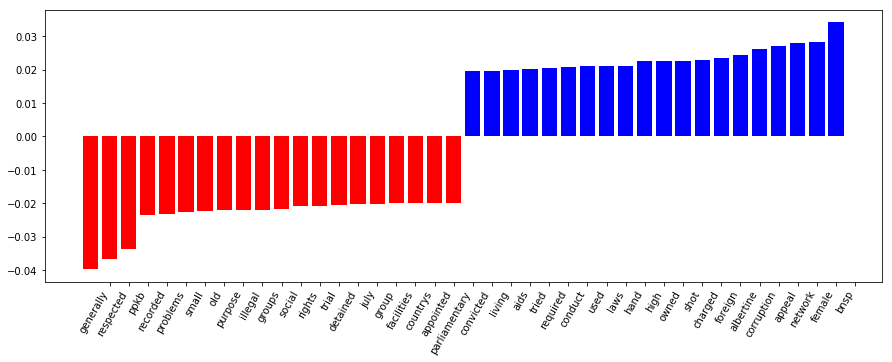

   Accuracy: 0.7585616438356164


In [141]:
fit_model_report_features(svm)

#### SVM with ngrams

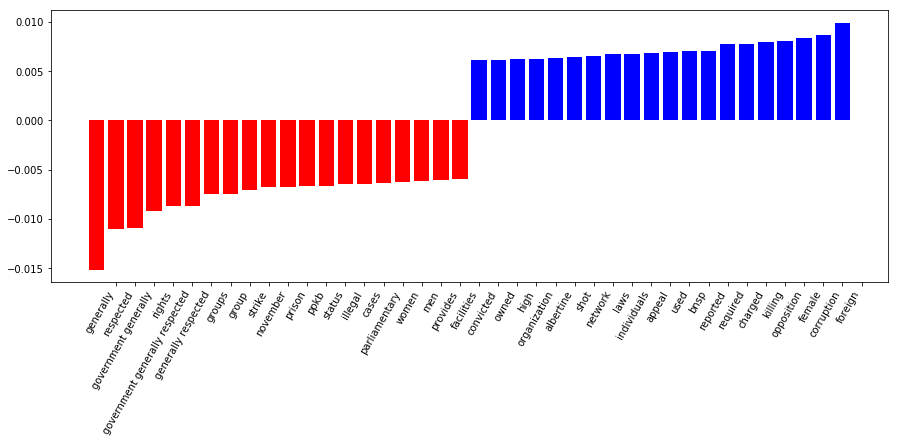

   Accuracy: 0.7688356164383562


In [167]:
fit_model_report_features(svm_ngrams)

#### SVM with ngrams and tfidf

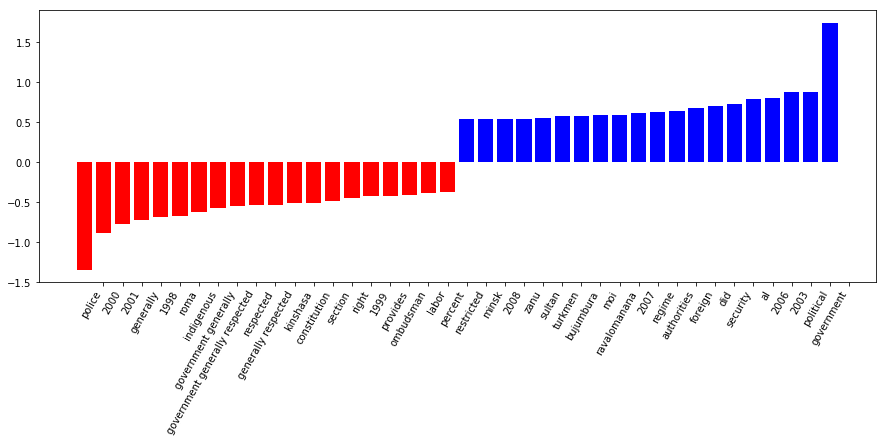

   Accuracy: 0.7964912280701755


In [119]:
fit_model_report_features(svm_ngrams_tfidf)

#### SGD no ngrams or tf idf

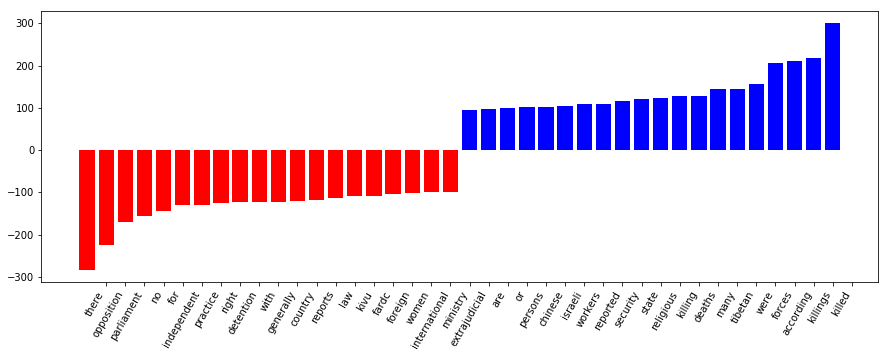

   Accuracy: 0.6526315789473685


In [124]:
fit_model_report_features(sgd)


### Try example 'KILL'

In [120]:
X_train, X_test, y_train, y_test= get_data('KILL',1999,2009, False)

   Extracting Data
      Cleaning text


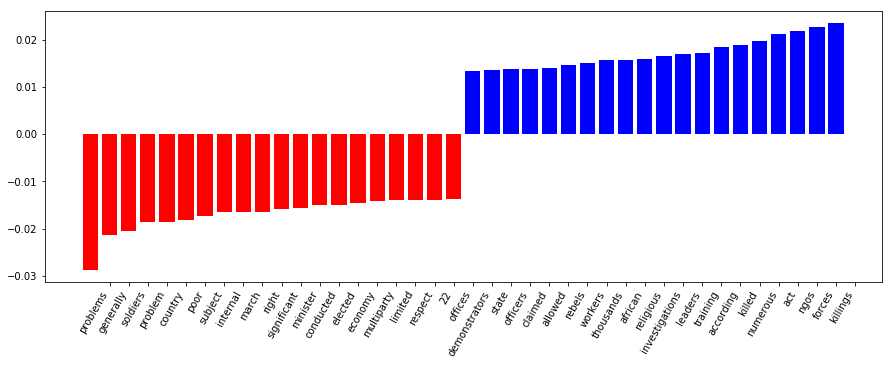

   Accuracy: 0.7596491228070176


In [125]:
fit_model_report_features(svm)

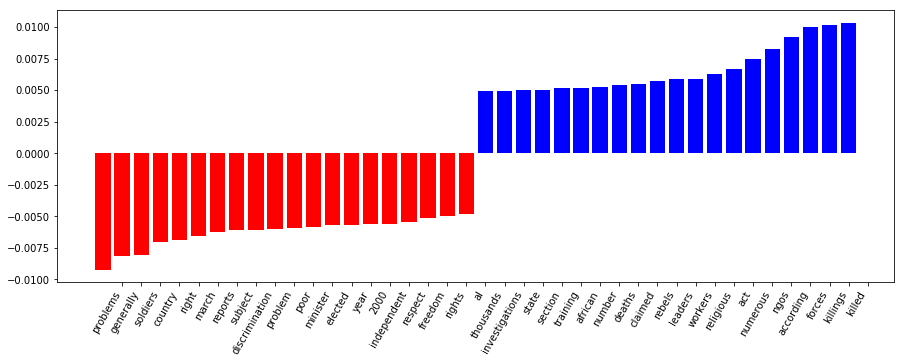

   Accuracy: 0.7614035087719299


In [126]:
fit_model_report_features(svm_ngrams)

looks like location based data is playing too much of a role in analysis